In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime
import yfinance as yf


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.signal import temporal_signal_split

C:\Users\akhan147\Anaconda3\envs\trader\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path
data_dir = Path(r'F:\cc_data')
model_dir = data_dir.absolute() / 'models'

In [4]:
# GPU support
DEVICE = torch.device('cpu') # cuda
shuffle=True
batch_size = 32

# Data

In [5]:
start = datetime.datetime(2020, 1, 1)
end_train = datetime.datetime(2024, 4, 1)
end_test = datetime.datetime.now()


|Rank	| Symbol |	Fund | Name |
|---|---|----|----|
|1	| SPY	| SPDR S&P 500 ETF Trust |
|2	| IVV	| iShares Core S&P 500 ETF |
|3	| VOO	| Vanguard S&P 500 ETF|
|4	| VTI	| Vanguard Total Stock Market ETF|
|5	| QQQ	| Invesco QQQ Trust Series I|
|6	| VEA	| Vanguard FTSE Developed Markets ETF|
|7	| VUG	| Vanguard Growth ETF|
|8	| VTV	| Vanguard Value ETF|
|9	| IEFA	| iShares Core MSCI EAFE ETF|
|10	| AGG	| iShares Core U.S. Aggregate Bond ETF

[Top ETFs](https://www.marketwatch.com/tools/top-25-etfs)

In [6]:
import yfinance as yf

tickers = ["SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "VUG", "VTV", "IEFA", "AGG"]

df_train = yf.download(tickers, start=start, end=end_train)
df_test = yf.download(tickers, start=end_train, end=end_test)
df_train.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Price                       Adj Close                                     \
Ticker                            AGG       IEFA         IVV         QQQ   
Date                                                                       
2020-01-02 00:00:00+00:00   99.801201  57.861572  302.929230  209.976120   
2020-01-03 00:00:00+00:00  100.093475  57.141933  300.599182  208.052734   
2020-01-06 00:00:00+00:00  100.013802  57.343781  301.787415  209.393280   
2020-01-07 00:00:00+00:00   99.907471  57.212139  300.961243  209.364136   
2020-01-08 00:00:00+00:00   99.792389  57.343781  302.492889  210.937744   

Price                                                                     \
Ticker                            SPY        VEA         VOO         VTI   
Date                                                                       
2020-01-02 00:00:00+00:00  302.208679  38.784164  276.999237  153.396179   
2020-01-03 00:00:00+00:00  299.920319  38.312691  274.975708  152.419876   
2020-01-06 00:00:00+00:00  301.064423  38.443649  276.006042  152.940582   
2020-01-07 00:00:00+00:00  300.217957  38.382530  275.244812  152.577911   
2020-01-08 00:00:00+00:00  301.817932  38.434921  276.665009  153.331039   

Price                                              ...   Volume            \
Ticker                            VTV         VUG  ...      AGG      IEFA   
Date                                               ...                      
2020-01-02 00:00:00+00:00  106.480408  179.231476  ...  6791400  10523100   
2020-01-03 00:00:00+00:00  105.631668  177.999664  ...  3664300   9663700   
2020-01-06 00:00:00+00:00  105.764275  179.144196  ...  8131600   7468300   
2020-01-07 00:00:00+00:00  105.357590  179.086014  ...  2883000   5815100   
2020-01-08 00:00:00+00:00  105.605141  180.492386  ...  7323100   8249700   

Price                                                                     \
Ticker                         IVV       QQQ       SPY      VEA      VOO   
Date                                                                       
2020-01-02 00:00:00+00:00  4070500  30969400  59151200  8229000  3142400   
2020-01-03 00:00:00+00:00  4290400  27518900  77709700  9697300  3247900   
2020-01-06 00:00:00+00:00  4212000  21655300  55653900  8579400  2777100   
2020-01-07 00:00:00+00:00  3632500  22139300  40496400  7884600  2251800   
2020-01-08 00:00:00+00:00  3912100  26397300  68296000  9948100  3719500   

Price                                                 
Ticker                         VTI      VTV      VUG  
Date                                                  
2020-01-02 00:00:00+00:00  3291100  1634700  1035800  
2020-01-03 00:00:00+00:00  3625400  1401600   909800  
2020-01-06 00:00:00+00:00  6813800  1546300   773700  
2020-01-07 00:00:00+00:00  2498400  1422200   848800  
2020-01-08 00:00:00+00:00  4244800  1401700   667200  

[5 rows x 60 columns]

In [7]:
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

scaled_train_data = scaler.fit_transform(df_train)
scaled_test_data = scaler.transform(df_test)

joblib.dump(scaler, model_dir / 'scaler.pkl')

['F:\\cc_data\\models\\scaler.pkl']

In [8]:
df_train = pd.DataFrame(scaled_train_data, index=df_train.index, columns= df_train.columns)
df_test = pd.DataFrame(scaled_test_data, index=df_test.index, columns= df_test.columns)
df_train.shape, df_test.shape

((1067, 60), (129, 60))

In [9]:
df_train.head()

Price                     Adj Close                                          \
Ticker                          AGG      IEFA       IVV       QQQ       SPY   
Date                                                                          
2020-01-02 00:00:00+00:00  0.078591 -0.502014 -1.434128 -1.821195 -1.435895   
2020-01-03 00:00:00+00:00  0.127960 -0.605562 -1.473383 -1.854182 -1.474697   
2020-01-06 00:00:00+00:00  0.114502 -0.576518 -1.453365 -1.831191 -1.455297   
2020-01-07 00:00:00+00:00  0.096541 -0.595460 -1.467283 -1.831691 -1.469650   
2020-01-08 00:00:00+00:00  0.077102 -0.576518 -1.441479 -1.804703 -1.442520   

Price                                                                        \
Ticker                          VEA       VOO       VTI       VTV       VUG   
Date                                                                          
2020-01-02 00:00:00+00:00 -0.616524 -1.435763 -1.441903 -0.947609 -1.711986   
2020-01-03 00:00:00+00:00 -0.714245 -1.473019 -1.475327 -0.994208 -1.740929   
2020-01-06 00:00:00+00:00 -0.687102 -1.454049 -1.457501 -0.986927 -1.714037   
2020-01-07 00:00:00+00:00 -0.699770 -1.468064 -1.469917 -1.009256 -1.715404   
2020-01-08 00:00:00+00:00 -0.688911 -1.441917 -1.444133 -0.995664 -1.682359   

Price                      ...    Volume                                \
Ticker                     ...       AGG      IEFA       IVV       QQQ   
Date                       ...                                           
2020-01-02 00:00:00+00:00  ... -0.165613 -0.031850 -0.403814 -0.940624   
2020-01-03 00:00:00+00:00  ... -1.218044 -0.165705 -0.323507 -1.093035   
2020-01-06 00:00:00+00:00  ...  0.285435 -0.507647 -0.352139 -1.352033   
2020-01-07 00:00:00+00:00  ... -1.480993 -0.765139 -0.563770 -1.330655   
2020-01-08 00:00:00+00:00  ...  0.013332 -0.385941 -0.461661 -1.142576   

Price                                                                        \
Ticker                          SPY       VEA       VOO       VTI       VTV   
Date                                                                          
2020-01-02 00:00:00+00:00 -0.658449 -0.603358 -0.624026 -0.329823 -0.882999   
2020-01-03 00:00:00+00:00 -0.219528 -0.431776 -0.583297 -0.173955 -1.077259   
2020-01-06 00:00:00+00:00 -0.741162 -0.562411 -0.765055  1.312639 -0.956669   
2020-01-07 00:00:00+00:00 -1.099646 -0.643603 -0.967855 -0.699420 -1.060091   
2020-01-08 00:00:00+00:00 -0.442168 -0.402468 -0.401229  0.114841 -1.077175   

Price                                
Ticker                          VUG  
Date                                 
2020-01-02 00:00:00+00:00 -0.051753  
2020-01-03 00:00:00+00:00 -0.282331  
2020-01-06 00:00:00+00:00 -0.531391  
2020-01-07 00:00:00+00:00 -0.393960  
2020-01-08 00:00:00+00:00 -0.726284  

[5 rows x 60 columns]

* `1194` : trading days
* (1194, 60) --> (1194, 10, 6, 15) 
* 1194 : num_samples,
* 10 : etfs,
* 6 : OHLC, Add CLose, Volume,
* 15 : bicket size (days), for time being only 1

In [10]:
df_train.index.min(), df_train.index.max()

(Timestamp('2020-01-02 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-28 00:00:00+0000', tz='UTC'))

In [11]:
df_test.index.min(), df_test.index.max()

(Timestamp('2024-04-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-10-02 00:00:00+0000', tz='UTC'))

In [12]:
# df.columns

In [13]:
df_train.to_csv(data_dir / 'top10_etf_train.csv')
df_test.to_csv(data_dir / 'top10_etf_test.csv')

In [14]:
data_numpy_test = df_test.values
data_numpy_test.shape

(129, 60)

In [15]:
data_numpy = df_train.values
data_numpy.shape

(1067, 60)

In [16]:
arrays = {}
arrays_test = {}
for level in df_train.columns.levels[1]:
    arrays[level] = df_train.xs(level, axis=1, level=1).to_numpy()
    arrays_test[level] = df_test.xs(level, axis=1, level=1).to_numpy()

In [17]:
arrays.keys()

dict_keys(['AGG', 'IEFA', 'IVV', 'QQQ', 'SPY', 'VEA', 'VOO', 'VTI', 'VTV', 'VUG'])

In [18]:
arrays['AGG'].shape

(1067, 6)

# Tabular data --> Temporal Graph data

In [19]:
num_timesteps_in = 15
num_timesteps_out = 5

In [20]:
indices = [(i, i + num_timesteps_in + num_timesteps_out) for i in range(data_numpy.shape[0] - num_timesteps_in - num_timesteps_out + 1)]
len(indices)

1048

In [21]:
indices[:5]

[(0, 20), (1, 21), (2, 22), (3, 23), (4, 24)]

In [22]:
indices[-5:]

[(1043, 1063), (1044, 1064), (1045, 1065), (1046, 1066), (1047, 1067)]

In [23]:
features = []
targets = []
for i, j in indices:
    
    features_bucket_list = []
    target_bucket_list = []
    
    for etf in arrays.keys():
        features_bucket_list.append(arrays[etf][i : i+num_timesteps_in, 0].T)
        target_bucket_list.append(arrays[etf][i+num_timesteps_in : j, 0].T)
    
    features_array_stack = np.stack(features_bucket_list, axis=0)
    target_array_stack = np.stack(target_bucket_list, axis=0)
    
    features.append(features_array_stack)
    targets.append(target_array_stack)

train_input = np.stack(features, axis=0)
train_target = np.stack(targets, axis=0)

train_input.shape, train_target.shape

((1048, 10, 15), (1048, 10, 5))

In [24]:
indices = [(i, i + num_timesteps_in + num_timesteps_out) for i in range(data_numpy_test.shape[0] - num_timesteps_in - num_timesteps_out + 1)]
len(indices)

110

In [25]:
indices[:5]

[(0, 20), (1, 21), (2, 22), (3, 23), (4, 24)]

In [26]:
indices[-5:]

[(105, 125), (106, 126), (107, 127), (108, 128), (109, 129)]

In [27]:
features = []
targets = []
for i, j in indices:
    
    features_bucket_list = []
    target_bucket_list = []
    
    for etf in arrays_test.keys():
        features_bucket_list.append(arrays_test[etf][i : i+num_timesteps_in, 0].T)
        target_bucket_list.append(arrays_test[etf][i+num_timesteps_in : j, 0].T)
    
    features_array_stack = np.stack(features_bucket_list, axis=0)
    target_array_stack = np.stack(target_bucket_list, axis=0)
    
    features.append(features_array_stack)
    targets.append(target_array_stack)

test_input = np.stack(features, axis=0)
test_target = np.stack(targets, axis=0)

test_input.shape, test_target.shape

((110, 10, 15), (110, 10, 5))

In [28]:
len(targets)

110

In [29]:
train_input.shape, train_target.shape

((1048, 10, 15), (1048, 10, 5))

In [30]:
features_array_stack.shape, target_array_stack.shape

((10, 15), (10, 5))

In [31]:
len(features_bucket_list), len(target_bucket_list)

(10, 10)

In [32]:
features_bucket_list[0].shape, target_bucket_list[0].shape

((15,), (5,))

# DataLoaders

In [33]:
# train_input = np.array(train_dataset.features) # (27399, 207, 2, 12) --> (, 10, 6, 15)
# train_target = np.array(train_dataset.targets) # (27399, 207, 12) --> (, 10, 15)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [34]:
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

# Training

In [35]:
train_input.shape

(1048, 10, 15)

In [36]:
num_nodes = 10

In [37]:
edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()
edge_index.shape

torch.Size([2, 100])

In [38]:
edge_attr = np.ones(edge_index.shape[1])
edge_attr.shape

(100,)

In [39]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Create a StaticGraphTemporalSignal object
# dataset = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[train_input], targets=[train_target])
# dataset_test = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[test_input], targets=[test_target])

dataset = StaticGraphTemporalSignal(edge_index, edge_attr, train_input, train_target)
dataset_test = StaticGraphTemporalSignal(edge_index, edge_attr, test_input, test_target)

In [40]:
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

## GConvLSTM

In [56]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM

class GConvLSTMModel(torch.nn.Module):
    def __init__(self, node_features, output_len):
        super(GConvLSTMModel, self).__init__()
        self.dcrnn = GConvLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, output_len)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.dcrnn(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h_0)
        return h, h_0, c_0

In [63]:
def evaluate_model(model, val_loader, h, c):
    loss = 0
    step = 0
    val_mape, val_mae = [], []
    
    model.eval()
    with torch.no_grad():
        for snapshot in val_loader:
            # snapshot = snapshot.to(device)
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            loss = loss + torch.mean(torch.abs(y_hat-snapshot.y)) 
            val_mape.append(mean_absolute_percentage_error(snapshot.y, y_hat))
            val_mae.append(mean_absolute_error(snapshot.y, y_hat))
            step += 1
        loss = loss / (step + 1)
    
    # print("Val MAE: {:.4f}".format(loss.item()))
    return loss, val_mape, val_mae

In [64]:
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [65]:
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [66]:
next(iter(dataset))


Data(x=[10, 15], edge_index=[2, 100], edge_attr=[100], y=[10, 5])

In [67]:
for time, snapshot in enumerate(train_loader):
    print(type(snapshot))
    print(len(snapshot))
    print(snapshot[0].shape, snapshot[1].shape)
    break
        
        # # snapshot = snapshot.to(device)
        # y_hat = dcrnn_model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        # loss = loss + torch.mean(torch.abs(y_hat-snapshot.y))

<class 'list'>
2
torch.Size([32, 10, 15]) torch.Size([32, 10, 5])


In [68]:
gclstm_model = GConvLSTMModel(node_features = train_input.shape[-1], 
                              output_len = train_target.shape[-1]
                             ).to(DEVICE)

optimizer = torch.optim.Adam(gclstm_model.parameters(), lr=0.01)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_losses, val_losses = [], []
train_mape, train_mae = [], []

best_model = None
best_va_loss = 1E6

for epoch in range(500):
    loss = 0
    h, c = None, None
    
    gclstm_model.train()
    for time, snapshot in enumerate(dataset):
        snapshot = snapshot.to(device)
        y_hat, h, c = gclstm_model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        loss = loss + torch.mean(torch.abs(y_hat-snapshot.y))
        train_mape.append(mean_absolute_percentage_error(snapshot.y, y_hat))
        train_mae.append(mean_absolute_error(snapshot.y, y_hat))
    
    loss = loss / (time+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_losses.append(loss.item())

    va_loss, val_mape, val_mae = evaluate_model(gclstm_model, dataset_test, h, c)
    val_losses.append(va_loss.item())
    
    if epoch % 10 == 0 :
        print(f"Epoch {epoch} \
                train RMSE: {sum(train_losses)/len(train_losses):.4E}, \
                MAE: {sum(train_mae)/len(train_mae):.4E}, \
                MAPE: {sum(train_mape)/len(train_mape):.2f}%"
             )
        print(f"\t \t Val RMSE: {sum(val_losses)/len(val_losses):.4E}, \
                MAE: {sum(val_mae)/len(val_mae):.4E}, \
                MAPE: {sum(val_mape)/len(val_mape):.2f}%"
             )

    if va_loss < best_va_loss:
        best_va_loss = va_loss
        best_model_state = gclstm_model.state_dict()
        torch.save(best_model_state, model_dir.absolute() / 'best_gclstm_model.pth')
        print("\t \t Best model saved with validation loss: {:.4f}".format(va_loss.item()))

    

Epoch 0                 train RMSE: 8.7067E-01,                 MAE: 8.7067E-01,                 MAPE: 178.64%
	 	 Val RMSE: 2.0766E+00,                 MAE: 2.0955E+00,                 MAPE: 99.73%
	 	 Best model saved with validation loss: 2.0766
	 	 Best model saved with validation loss: 1.8783
	 	 Best model saved with validation loss: 1.6821
	 	 Best model saved with validation loss: 1.5147
	 	 Best model saved with validation loss: 1.3788
	 	 Best model saved with validation loss: 1.2709
	 	 Best model saved with validation loss: 1.1796
	 	 Best model saved with validation loss: 1.1115
	 	 Best model saved with validation loss: 1.0676
	 	 Best model saved with validation loss: 0.9964
Epoch 10                 train RMSE: 5.0484E-01,                 MAE: 5.0484E-01,                 MAPE: 181.87%
	 	 Val RMSE: 1.3696E+00,                 MAE: 9.1742E-01,                 MAPE: 55.17%
	 	 Best model saved with validation loss: 0.9092
	 	 Best model saved with validation loss: 0.8520
	

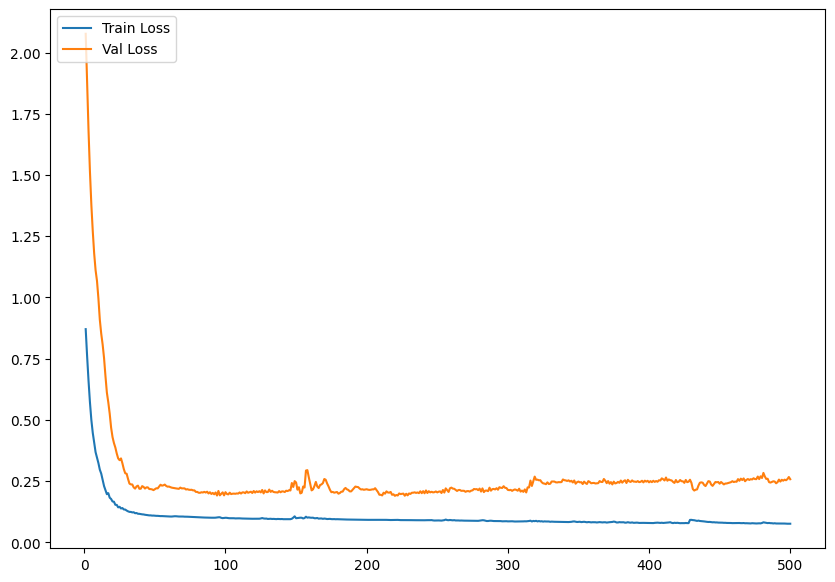

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.legend(loc="upper left")
plt.show()

In [70]:
gclstm_model.load_state_dict(torch.load(model_dir.absolute() / 'best_gclstm_model.pth'))


C:\Users\akhan147\AppData\Local\Temp\ipykernel_5952\2272950988.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gclstm_model.load_state_dict(torch.load(model_dir.absolute

<All keys matched successfully>

# Eval

## Test set

In [73]:
"""Make predictions for test data"""
gclstm_model.eval()

y_preds = list()
y_true = list()

for snapshot in dataset_test:
    y = snapshot.y.cpu().numpy()
    y_pred, h, c = gclstm_model(snapshot.x, snapshot.edge_index, 
                         snapshot.edge_attr, h, c)
    
    y_pred = y_pred.view(len(snapshot.x), -1).cpu().detach().numpy()

    # y = np.array((y * std_speed) +  mean_speed)
    # y_pred = np.array((y_pred * std_speed) +  mean_speed)
    y_preds.extend(list(y_pred))
    y_true.extend(list(y))
    
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/(10)), 10, 5)
y_true = y_true.reshape(int(y_true.shape[0]/(10)), 10, 5)

In [74]:
y_preds.shape, y_true.shape

((110, 10, 5), (110, 10, 5))

In [75]:
plt.style.use('ggplot')


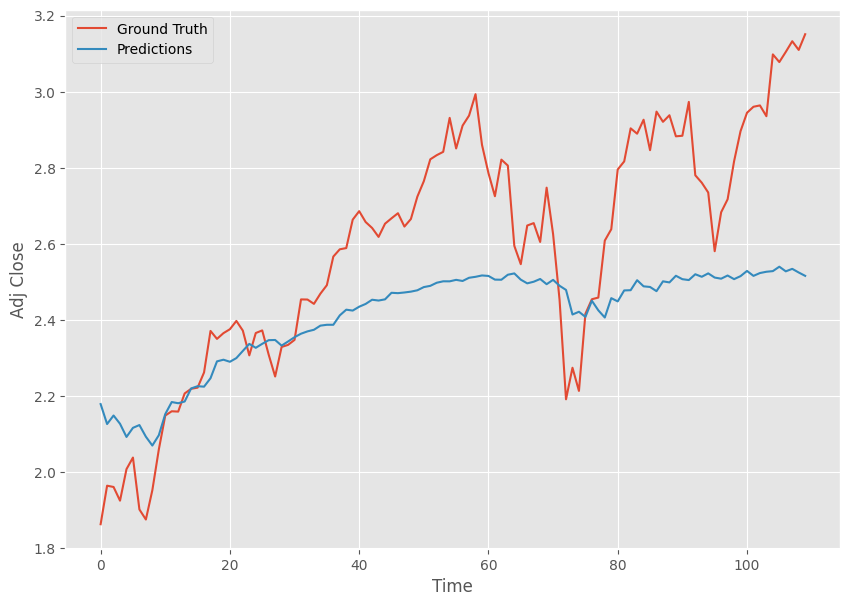

In [76]:
"""show one sensor time series only first time step"""
y_sample = y_true[:, 2, 0]
y_pred_sample = y_preds[:, 2, 0]

plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend(loc="upper left")
plt.show()

## Train set

In [ ]:
"""Make predictions for test data"""
gclstm_model.eval()

y_preds = list()
y_true = list()

for snapshot in dataset:
    y = snapshot.y.cpu().numpy()
    y_pred = gclstm_model(snapshot.x, snapshot.edge_index, 
                         snapshot.edge_attr
                        ).view(len(snapshot.x), -1).cpu().detach().numpy()

    # y = np.array((y * std_speed) +  mean_speed)
    # y_pred = np.array((y_pred * std_speed) +  mean_speed)
    y_preds.extend(list(y_pred))
    y_true.extend(list(y))
    
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/(10)), 10, 5)
y_true = y_true.reshape(int(y_true.shape[0]/(10)), 10, 5)

In [ ]:
y_preds.shape, y_true.shape

In [ ]:
plt.style.use('ggplot')


In [ ]:
"""show one sensor time series only first time step"""
y_sample = y_true[:, 2, 0]
y_pred_sample = y_preds[:, 2, 0]

plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend(loc="upper left")
plt.show()